In [1]:
# Importing necessary libraries
import numpy as np 
import pandas as pd

import os
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf

In [2]:
# Defining my directories for the images

test_path = '../input/chest-xray-pneumonia/chest_xray/test/'
val_path = '../input/chest-xray-pneumonia/chest_xray/val/'
train_path = '../input/chest-xray-pneumonia/chest_xray/train/'

In [3]:
# Index 0 indicates Pneumonia and index 1 indicates Normal

os.listdir(val_path)

['PNEUMONIA', 'NORMAL']

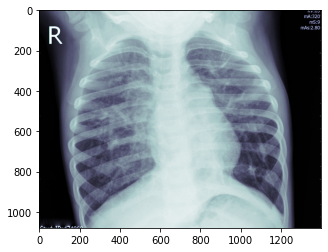

In [4]:
# Observing A Random Image

from matplotlib.image import imread 
example = train_path+'PNEUMONIA/' + os.listdir(train_path+'PNEUMONIA')[-5]
plt.imshow(imread(example),cmap='bone')

In [5]:
# Looking at size of directory

# Train path
print(len(os.listdir(train_path+'PNEUMONIA/')))
print(len(os.listdir(train_path+'NORMAL/')))
print()

# Val path
print(len(os.listdir(val_path+'PNEUMONIA/')))
print(len(os.listdir(val_path+'NORMAL/')))
print()

# Test path
print(len(os.listdir(test_path+'PNEUMONIA/')))
print(len(os.listdir(test_path+'NORMAL/')))
print()

3875
1341

8
8

390
234



In [6]:
# Code to resize the images

image_size = 180

from skimage import color

def resize_image(image_path):
    image = imread(image_path)
    image_shape = image.shape
    if (len(image.shape) == 3):
        image = color.rgb2gray(image) 
    image_adjusted = tf.image.resize(image.reshape(image_shape[0],image_shape[1],1),(image_size,image_size))
    return image_adjusted

labels = ['PNEUMONIA','NORMAL']

def readjust_training_data(directory):
    data = []
    for label in labels:
        i=0 
        for image in os.listdir(directory+label):
            example_path = directory + label + '/' + image
            try:
                reshaped_image = resize_image(example_path)
                data.append([reshaped_image,labels.index(label)])
            except Exception as e:
                print(label + ": "+ str(i))
                print(e)
            i = i + 1
    return np.array(data)

In [7]:
val = readjust_training_data(val_path)
val.shape

2022-07-27 00:40:05.535814: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-07-27 00:40:05.655210: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-07-27 00:40:05.656376: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-07-27 00:40:05.659643: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

(16, 2)

In [8]:
train = readjust_training_data(train_path)
train.shape

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:30: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


(5216, 2)

In [9]:
test = readjust_training_data(test_path)
test.shape

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:30: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


(624, 2)

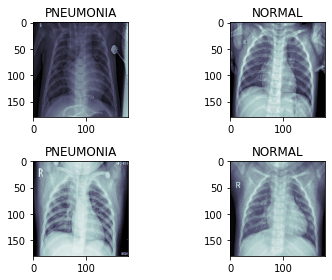

In [10]:
# Testing if resizing images worked 

fig,((ax1,ax2),(ax3,ax4)) = plt.subplots(nrows=2,ncols=2)
ax1.imshow(train[0][0],cmap='bone')
ax1.set_title(labels[train[0][1]])
ax2.imshow(train[-1][0],cmap='bone')
ax2.set_title(labels[train[-1][1]])
ax3.imshow(train[1][0],cmap='bone')
ax3.set_title(labels[train[1][1]])
ax4.imshow(train[-2][0],cmap='bone')
ax4.set_title(labels[train[-2][1]])
plt.tight_layout()

In [11]:
# Identifying imbalance between two categories in train data

print('Pneumonia: ' + str(len(os.listdir(train_path + 'PNEUMONIA'))))
print('Normal: ' + str(len(os.listdir(train_path + 'NORMAL'))))

Pneumonia: 3875
Normal: 1341


In [10]:
# Organizing training and test data

# Putting data in array
x_train = []
y_train = []

x_val = []
y_val = []

x_test = []
y_test = []

for image,label in train:
    x_train.append(image)
    y_train.append(label)

for image,label in test:
    x_test.append(image)
    y_test.append(label)
    
for image,label in val:
    x_val.append(image)
    y_val.append(label)

In [11]:
# Reformatting arrays
x_train = np.array(x_train)/255
x_test = np.array(x_test)/255
x_val = np.array(x_val)/255

x_train = x_train.reshape(-1,180,180,1)
y_train = np.array(y_train)

x_test = x_test.reshape(-1,180,180,1)
y_test = np.array(y_test)

x_val = x_val.reshape(-1,180,180,1)
y_val = np.array(y_val)

In [12]:
x_train.shape

(5216, 180, 180, 1)

In [13]:
y_train.shape

(5216,)

In [14]:
# Data Augmentation To Balance Training Data

from tensorflow.keras.preprocessing.image import ImageDataGenerator
image_gen = ImageDataGenerator(rotation_range=10,width_shift_range=0.1,height_shift_range=0.1,
                    shear_range=0.1,zoom_range=0.1,horizontal_flip=False)

image_gen.fit(x_train)

In [39]:
# Making Neural Network

image_shape = (180,180,1)
from tensorflow.keras.models import Sequential 
from tensorflow.keras.layers import Dense,Conv2D,MaxPool2D,Dropout,Flatten, BatchNormalization

model = Sequential()

model.add(Conv2D(32 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu' , input_shape = image_shape))
model.add(BatchNormalization())
model.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))
model.add(Dropout(0.2))

model.add(Conv2D(64 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'))
model.add(BatchNormalization())
model.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))
model.add(Dropout(0.2))

model.add(Conv2D(64 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'))
model.add(BatchNormalization())
model.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))
model.add(Dropout(0.2))

model.add(Conv2D(128 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'))
model.add(BatchNormalization())
model.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))
#model.add(Dropout(0.2))

model.add(Conv2D(256 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'))
model.add(BatchNormalization())
model.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))
model.add(Dropout(0.1))

model.add(Flatten())
model.add(Dense(units = 128 , activation = 'relu'))

model.add(Dense(units = 1 , activation = 'sigmoid'))
model.compile(optimizer = "rmsprop" , loss = 'binary_crossentropy' , metrics = ['accuracy'])

model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_15 (Conv2D)           (None, 180, 180, 32)      320       
_________________________________________________________________
batch_normalization_15 (Batc (None, 180, 180, 32)      128       
_________________________________________________________________
max_pooling2d_15 (MaxPooling (None, 90, 90, 32)        0         
_________________________________________________________________
dropout_15 (Dropout)         (None, 90, 90, 32)        0         
_________________________________________________________________
conv2d_16 (Conv2D)           (None, 90, 90, 64)        18496     
_________________________________________________________________
batch_normalization_16 (Batc (None, 90, 90, 64)        256       
_________________________________________________________________
max_pooling2d_16 (MaxPooling (None, 45, 45, 64)       

In [40]:
# First Attempt of fitting the model
model.fit(image_gen.flow(x_train,y_train,batch_size=32),epochs=12,validation_data=image_gen.flow(x_test,y_test))

Epoch 1/12
163/163 [==============================] - 17s 98ms/step - loss: 0.5936 - accuracy: 0.8577 - val_loss: 40.1255 - val_accuracy: 0.6250
Epoch 2/12
163/163 [==============================] - 15s 95ms/step - loss: 0.2274 - accuracy: 0.9197 - val_loss: 47.2376 - val_accuracy: 0.6250
Epoch 3/12
163/163 [==============================] - 16s 97ms/step - loss: 0.1778 - accuracy: 0.9413 - val_loss: 57.4927 - val_accuracy: 0.6250
Epoch 4/12
163/163 [==============================] - 15s 93ms/step - loss: 0.1654 - accuracy: 0.9502 - val_loss: 11.7036 - val_accuracy: 0.6250
Epoch 5/12
163/163 [==============================] - 16s 96ms/step - loss: 0.1688 - accuracy: 0.9434 - val_loss: 15.7669 - val_accuracy: 0.6298
Epoch 6/12
163/163 [==============================] - 15s 90ms/step - loss: 0.1416 - accuracy: 0.9528 - val_loss: 2.3001 - val_accuracy: 0.7853
Epoch 7/12
163/163 [==============================] - 17s 102ms/step - loss: 0.1318 - accuracy: 0.9578 - val_loss: 0.9287 - val_acc

In [41]:
# Evaluate the model
model.evaluate(x_test,y_test)

20/20 [==============================] - 0s 10ms/step - loss: 0.4468 - accuracy: 0.9006


[0.4468332827091217, 0.9006410241127014]

In [42]:
# Calculation predictions and evaluating the model

pred = model.predict(x_test)
predictions = pred>0.5

In [43]:
# Classification Report and Confusion Matrix

from sklearn.metrics import classification_report, confusion_matrix

print(classification_report(y_test,predictions))
print()
print(confusion_matrix(y_test,predictions))

              precision    recall  f1-score   support

           0       0.88      0.98      0.92       390
           1       0.95      0.77      0.85       234

    accuracy                           0.90       624
   macro avg       0.92      0.88      0.89       624
weighted avg       0.91      0.90      0.90       624


[[381   9]
 [ 53 181]]


In [44]:
# Let's save the model before analyzing this data further
from tensorflow.keras.models import load_model
model.save('xray_pneumonia_imaging_version2_90percent.h5')

In [24]:
# This model has 90% accuracy

In [2]:
# I'm going to load the model and train it for 5 more epochs

In [20]:
from tensorflow.keras.callbacks import EarlyStopping
early_stop = EarlyStopping(monitor='val_loss',patience=3)

In [22]:
from tensorflow.keras.models import load_model
model2 = load_model('../input/cnn-model-version-2/xray_pneumonia_imaging_version2_90percent.h5')

In [24]:
# Fitting my previous model which has 90 percent accuracy on test day for 5 more epochs

model2.fit(image_gen.flow(x_train,y_train,batch_size=32),epochs=5,validation_data=image_gen.flow(x_test,y_test))

Epoch 1/5
163/163 [==============================] - 15s 92ms/step - loss: 0.0925 - accuracy: 0.9739 - val_loss: 0.7658 - val_accuracy: 0.7965
Epoch 2/5
163/163 [==============================] - 14s 87ms/step - loss: 0.0805 - accuracy: 0.9755 - val_loss: 7.9930 - val_accuracy: 0.7612
Epoch 3/5
163/163 [==============================] - 15s 90ms/step - loss: 0.0921 - accuracy: 0.9757 - val_loss: 3.0634 - val_accuracy: 0.6506
Epoch 4/5
163/163 [==============================] - 14s 86ms/step - loss: 0.0935 - accuracy: 0.9734 - val_loss: 1.5778 - val_accuracy: 0.8301
Epoch 5/5
163/163 [==============================] - 14s 88ms/step - loss: 0.0910 - accuracy: 0.9741 - val_loss: 1.5689 - val_accuracy: 0.8542


In [25]:
# After evaluating the second iteration of the model, the accuracy on test data is now 91 percent

pred = model2.predict(x_test)
predictions = pred>0.5

from sklearn.metrics import classification_report, confusion_matrix

print(classification_report(y_test,predictions))
print()
print(confusion_matrix(y_test,predictions))

              precision    recall  f1-score   support

           0       0.89      0.97      0.93       390
           1       0.95      0.80      0.87       234

    accuracy                           0.91       624
   macro avg       0.92      0.89      0.90       624
weighted avg       0.91      0.91      0.91       624


[[380  10]
 [ 47 187]]


In [27]:
model2.save('xray_pneumonia_imaging_version3_91percent.h5')

In [28]:
# Let's repeat the same process again 

In [29]:
model3 = load_model('./xray_pneumonia_imaging_version3_91percent.h5')

In [32]:
model3.fit(image_gen.flow(x_train,y_train,batch_size=32),epochs=5,validation_data=image_gen.flow(x_test,y_test))

Epoch 1/5
163/163 [==============================] - 15s 89ms/step - loss: 0.0805 - accuracy: 0.9734 - val_loss: 3.4783 - val_accuracy: 0.6971
Epoch 2/5
163/163 [==============================] - 15s 90ms/step - loss: 0.0735 - accuracy: 0.9758 - val_loss: 101.0549 - val_accuracy: 0.6250
Epoch 3/5
163/163 [==============================] - 14s 86ms/step - loss: 0.0643 - accuracy: 0.9781 - val_loss: 0.6867 - val_accuracy: 0.8686
Epoch 4/5
163/163 [==============================] - 15s 92ms/step - loss: 0.0683 - accuracy: 0.9776 - val_loss: 5.7727 - val_accuracy: 0.6282
Epoch 5/5
163/163 [==============================] - 14s 87ms/step - loss: 0.0685 - accuracy: 0.9774 - val_loss: 0.8164 - val_accuracy: 0.8974


In [33]:
# Fitting the model for another 5 epochs has brought it's accuracy up to 92 percent on test data

pred = model3.predict(x_test)
predictions = pred>0.5

print(classification_report(y_test,predictions))
print()
print(confusion_matrix(y_test,predictions))

              precision    recall  f1-score   support

           0       0.93      0.95      0.94       390
           1       0.91      0.88      0.89       234

    accuracy                           0.92       624
   macro avg       0.92      0.91      0.92       624
weighted avg       0.92      0.92      0.92       624


[[369  21]
 [ 28 206]]


In [34]:
model3.save('xray_pneumonia_imaging_version4_92percent.h5')